# **Prediction of the price of First Majestic Stock**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
sns.set_style('whitegrid')
%matplotlib inline

In [9]:
import yfinance as yf

In [10]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [11]:
# Setting time period for which stock price would be collected 
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

In [12]:
stock_list = ['FR.TO']

In [13]:
# Useful if I have more than one stock
for stock in stock_list:
    globals()[stock] = yf.download(stock, 
                       start=start, 
                       end=end, 
                       progress=False,
                       group_by = 'ticker')

In [14]:
# Stock Dataframe
FR = globals()['FR.TO']
#FR.head()

### **Calculating Moving Average**

In [15]:
m_avg = 50
column_name = 'MA for %s days' %str(m_avg)
FR[column_name] = FR['Adj Close'].rolling(window = m_avg, center = True).mean()

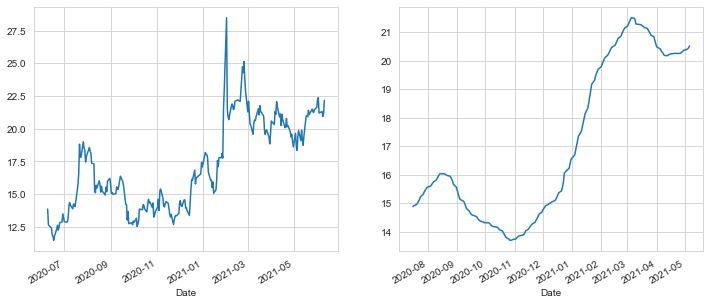

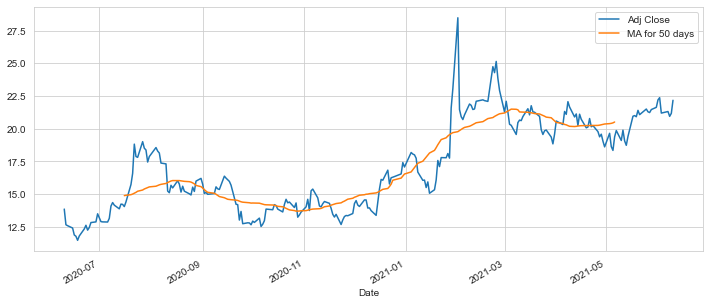

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#FR[['Adj Close','Move Avg for 50 days']].plot();
FR['Adj Close'].plot(ax = ax[0]);
FR['MA for 50 days'].plot(ax = ax[1]);
FR[['Adj Close','MA for 50 days']].plot(figsize=(12,5));

### **Calculating Daily Return using 'percent change' method**

In [17]:
FR.head()

,Open,High,Low,Close,Adj Close,Volume,MA for 50 days
Date,,,,,,,
2020-06-10,13.29,13.89,12.76,13.86,13.856302,1480100,NaN
2020-06-11,13.67,13.92,12.57,12.66,12.656622,1360900,NaN
2020-06-12,12.97,13.16,12.47,12.59,12.586641,1071000,NaN
2020-06-15,12.00,12.51,11.53,12.41,12.406689,1039000,NaN
2020-06-16,12.42,12.55,11.83,11.88,11.876831,1158200,NaN


In [18]:
FR['Daily Return'] = FR['Adj Close'].pct_change()

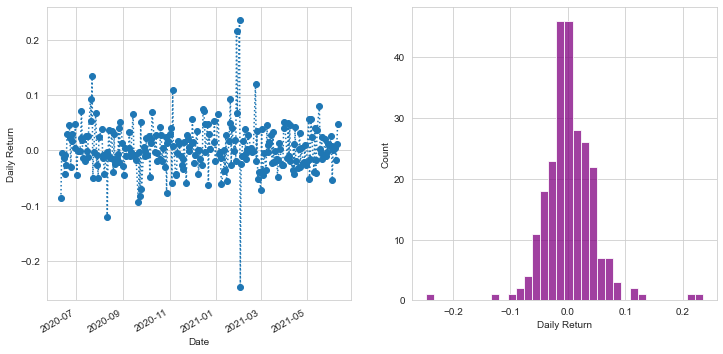

In [19]:
# Using subplots and using the axes objects in two different ways 
fig, ax = plt.subplots(1,2, figsize = (12,6))

FR['Daily Return'].dropna().plot(ax= ax[0], style = [':'], marker = 'o', ylabel = 'Daily Return')
ax[1] = sns.histplot(FR['Daily Return'].dropna(), color ='purple');

### **Estimating Value at Risk**

In [20]:
FR.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA for 50 days',
       'Daily Return'],
      dtype='object')

In [21]:
# 95% confidence that daily return will be higher than this value. Or daily loss will be less than the absolute value
Conf_95 = FR['Daily Return'].quantile(0.01)
Conf_95

-0.0898165254384905

In [22]:
Invest = 1500

In [23]:
# Value at Risk
VaR = abs(round(Conf_95, 3)*Invest)

In [24]:
VaR

135.0

### **Using Widgets to modify the start date and rolling moving average**

In [25]:
# Using the decorator for the Interact Function

@interact(stock = fixed('FR.TO'), period_years = (1,5), window1_days = (10,50), window2_days = (100,200,100))
def moving_avg (stock, period_years = 1, window1_days = 20, window2_days = 100):
    
    # Setting time period for which stock price would be collected 
    end = datetime.now()
    start = datetime(end.year - period_years, end.month, end.day)
    
    data = yf.download(stock, 
                       start=start, 
                       end=end, 
                       progress=False,
                       group_by = 'ticker')
    
    #m_avg = window_days
    first_moving_avg = 'MA for %s days' %str(window1_days)
    second_moving_avg = 'MA for %s days' %str(window2_days)
    data[first_moving_avg] = data['Adj Close'].rolling(window = window1_days, center = False).mean()
    data[second_moving_avg] = data['Adj Close'].rolling(window = window2_days, center = False).mean()
    
    return data[['Adj Close', first_moving_avg, second_moving_avg]].plot(ylabel = 'Market Value', figsize=(15,5));   
    

interactive(children=(IntSlider(value=1, description='period_years', max=5, min=1), IntSlider(value=20, descri…

In [26]:
# Without using the decorator for the Interact Function
interact(moving_avg, stock = ['FR.TO', 'ACO-X.TO'], period_years = (1,5), window1_days = (10,50), window2_days = (100,200,100));

interactive(children=(Dropdown(description='stock', options=('FR.TO', 'ACO-X.TO'), value='FR.TO'), IntSlider(v…

### **Prediction of Adj Closing Price using LSTM RNN**

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [187]:
def training_data (stock, period_years = 1, test_ratio = 0.2):
    
    # Setting the time period for which the stock price would be collected 
    
    #today = datetime.now()
    #End date is one month before today. That last month will be used as the test data   
    #end = datetime(today.year, today.month - 1, today.day)
    end = datetime.now()
    start = datetime(end.year - period_years, end.month, end.day)
    
    # importing data from yahoo finance
    data = yf.download(stock, 
                       start=start, 
                       end=end, 
                       progress=False,
                       group_by = 'ticker')
    
    # Creating an array with the Adj Close values for the specified time period. 
    # Reshape to create a column array
    data_price = np.array(data['Adj Close'])
    data_price = data_price.reshape(-1,1)
    
    # Normalizing the data
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(data_price)
    
    # Creating a data structure with 60 timesteps (X_data) and 1 output (y_data)
    X_data = []
    y_data = []
    range_max = len(training_set_scaled)
    
    for i in range(60, range_max):
        X_data.append(training_set_scaled[i-60:i, 0])
        y_data.append(training_set_scaled[i, 0])
    
    # Last rows (test_rows) will be used as the test data
    test_rows = int(test_ratio*len(X_data))
    train_limit = len(X_data) - test_rows
   
    
    X_train, y_train = np.array(X_data[:train_limit]), np.array(y_data[:train_limit])
    X_test, y_test = np.array(X_data[train_limit:]), np.array(y_data[train_limit:])
    
    print(f'The lengths of X_train and X_test are {len(X_train)} and {len(X_test)}')
    
    return X_train, y_train, X_test, y_test, training_set_scaled, sc, data 

In [194]:
X_train, y_train, X_test, y_test, training_set_scaled, sc, data = training_data ('FR.TO', 5, 0.2)

The lengths of X_train and X_test are 956 and 239


In [195]:
X_test.shape

(239, 60)

In [197]:
# Adding the third dimension required by LSTM
# "1" at the end refers to the third dimension. In this case X_train is a 2D matrix, so third dimension needs to be 1.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [198]:
X_train.shape

(956, 60, 1)

### **Model Training**

In [199]:
# Building the RNN

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [200]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [201]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
30/30 [==============================] - 10s 68ms/step - loss: 0.0149
Epoch 2/100
30/30 [==============================] - 2s 67ms/step - loss: 0.0034
Epoch 3/100
30/30 [==============================] - 2s 66ms/step - loss: 0.0028
Epoch 4/100
30/30 [==============================] - 2s 68ms/step - loss: 0.0025
Epoch 5/100
30/30 [==============================] - 2s 68ms/step - loss: 0.0023
Epoch 6/100
30/30 [==============================] - 2s 67ms/step - loss: 0.0020
Epoch 7/100
30/30 [==============================] - 2s 67ms/step - loss: 0.0020
Epoch 8/100
30/30 [==============================] - 2s 68ms/step - loss: 0.0020
Epoch 9/100
30/30 [==============================] - 2s 69ms/step - loss: 0.0017
Epoch 10/100
30/30 [==============================] - 2s 74ms/step - loss: 0.0021
Epoch 11/100
30/30 [==============================] - 2s 74ms/step - loss: 0.0020
Epoch 12/100
30/30 [==============================] - 2s 70ms/step - loss: 0.0017
Epoch 13/100
30/30 [====

### **Prediction of stock price**

In [202]:
def predict(test_data, model):
    
    """
    Model is the fitted model obtained during training above
    """
    test_data_reshaped = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

    predicted_stock_price = regressor.predict(test_data_reshaped)

    # This is to generate the actual price from normalized values
    predicted_price = sc.inverse_transform(predicted_stock_price)
    
    return predicted_price

In [203]:
predicted_stock_price = predict(X_test, regressor)

In [204]:
# This is the y_test array obtained from splitting original data in above function "training_data"
actual_stock_price_reshaped = y_test.reshape(-1,1)
# "inverse_transform" generates the real values from normalized values
actual_stock_price = sc.inverse_transform(actual_stock_price_reshaped)

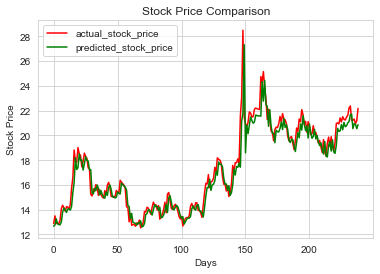

In [205]:
# Creating a dataframe with the actual and predicted stock prices. Dataframe is used below to plot the price trends
stock_df = pd.DataFrame({'actual_stock_price': actual_stock_price.flatten(),
                         'predicted_stock_price' : predicted_stock_price.flatten()}, 
                          index = [i for i in range(len(actual_stock_price))])

stock_df.plot(style = ['-','-'], color = ['red', 'green'], xlabel = 'Days', ylabel = 'Stock Price', title = 'Stock Price Comparison');

### **Forecasting stock price**

In [206]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-10,16.400000,16.889999,15.74,15.900000,15.895758,1603000
2016-06-13,16.270000,16.430000,15.74,16.110001,16.105703,1371600
2016-06-14,16.200001,16.230000,15.36,15.740000,15.735801,1015700
2016-06-15,15.810000,16.820000,15.70,16.639999,16.635559,1180400
2016-06-16,17.500000,17.559999,15.80,16.110001,16.105703,1135800


In [216]:
# This is the number of days into the future I want to predict stock price 
forecast_days = 60

# I need last 60 days of actual price data
data_price = np.array(data[-60:]['Adj Close'])
data_price_reshaped = data_price.reshape(-1,1)

# This list includes the dates of the last 60 stock prices. The following day will be added for every new price prediction. 
forecast_dates = list(data[-60:].index.date)

for i in range(forecast_days):
    
    # Normalizing (scaling) the data
    X_forecast = sc.fit_transform(data_price_reshaped)
    
    # Need to reshape the X_forecast data to an array (1, 60)
    y_forecast = predict(X_forecast.reshape(1,-1), regressor)
    # y_forecast is the actual price (not scaled)
    
    
    
    # Adding the last forecasted value to the original price array  
    data_price = np.append(data_price, y_forecast)
    # Selecting the last 60 values which include the latest forecasted price
    data_price_reshaped = data_price[-60:].reshape(-1,1)
    
    # Date generation
    new_day = forecast_dates[-1] + timedelta(days=+1)
    forecast_dates.append(new_day)
    
# Creating a dataframe with the forecast data and corresponding dates
# Not all forecasted dates correspond to trading dates as weekend/holidays were not excluded during Date Generation above 
forecast_data = pd.DataFrame(data_price, index = forecast_dates, columns = ['Forecast Stock Price'])

In [217]:
def forecast(data, forecast_data):

    plt.plot(data['Adj Close'])
    plt.plot(forecast_data['Forecast Stock Price'], alpha = 0.5)

    plt.legend(['Actual_Stock_Price', 'Forecast_Stock_Price'], loc='upper left' )
    #plt.show()
     

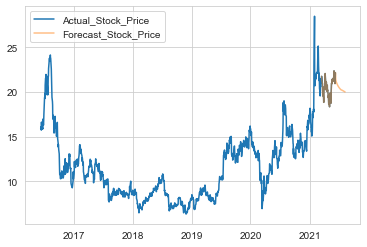

In [218]:
plot_forecast(data, forecast_data)

### **Forecasting Function**

In [292]:
def forecast(data, forecasting_days, plot_last_days):


    # This is the number of days into the future I want to predict stock price 
    forecast_days = forecasting_days

    # I need last 60 days of actual price data
    data_price = np.array(data[-60:]['Adj Close'])
    data_price_reshaped = data_price.reshape(-1,1)

    # This list includes the dates of the last 60 stock prices. The following day will be added for every new price prediction. 
    forecast_dates = list(data[-60:].index.date)

    for i in range(forecast_days):

        # Normalizing (scaling) the data
        X_forecast = sc.fit_transform(data_price_reshaped)

        # Need to reshape the X_forecast data to an array (1, 60)
        y_forecast = predict(X_forecast.reshape(1,-1), regressor)
        # y_forecast is the actual price (not scaled)



        # Adding the last forecasted value to the original price array  
        data_price = np.append(data_price, y_forecast)
        # Selecting the last 60 values which include the latest forecasted price
        data_price_reshaped = data_price[-60:].reshape(-1,1)

        # Date generation
        new_day = forecast_dates[-1] + timedelta(days=+1)
        forecast_dates.append(new_day)

    # Creating a dataframe with the forecast data and corresponding dates
    # Not all forecasted dates correspond to trading dates as weekend/holidays were not excluded during Date Generation above 
    forecast_data = pd.DataFrame(data_price, index = forecast_dates, columns = ['Forecast Stock Price'])
    
    #plotting
    plt.figure(figsize = (12,5))
    plt.plot(data['Adj Close'][-plot_last_days:])
    plt.plot(forecast_data['Forecast Stock Price'], alpha = 0.7, color = 'red')
    plt.legend(['Actual_Stock_Price', 'Forecast_Stock_Price'], loc='upper left' )
    plt.xticks(rotation = 45)    

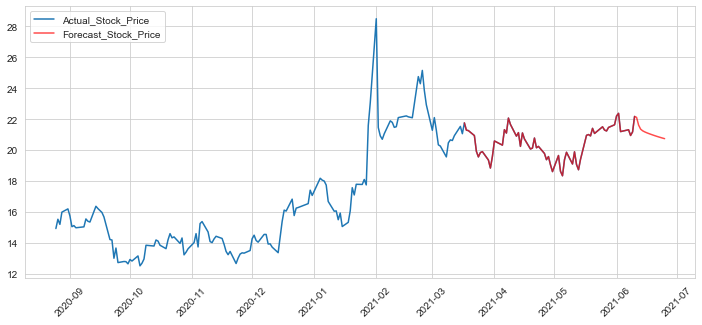

In [293]:
forecast(data, forecasting_days = 15, plot_last_days = 200)